## Setup imports

In [1]:
# Bring your packages onto the path
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..")))

import math
import itertools
import numpy as np

# This is to supress future warnings about sklearn's nmi function.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from analysis.entropy import *
from analysis.clustering import *
from analysis.visualize import pie_chart
from analysis.analysis_utils import Mouse, find_file
from analysis.resampling import Resampler
from analysis.sig_proc import Deconvoluter
from analysis.graph_analysis_utils import NeuronNetwork
from IPython.core.interactiveshell import InteractiveShell

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

##### We load & preprocess the data for a mouse.

In [3]:
s = pd.read_csv(find_file("Hen_Lab/Mice", "drd218_EPM_S.csv"), header=None)
c = pd.read_csv(find_file("Hen_Lab/Mice", "drd218_EPM_C.csv"), header=None)
behavior = pd.read_csv(find_file("Hen_Lab/Mice", "drd218_EPM_Behavior.csv"), header=None)

# Reindex neuron column vectors from 0,1,2,...,n ---> 1,2,3,...,n,n+1
s.columns = [col+1 for col in s.columns]
c.columns = [col+1 for col in c.columns]

behavior_column_names = ['Trial_time',
                         'Recording_time',
                         'X_center',
                         'Y_center',
                         'Area',
                         'Areachange',
                         'Elongation',
                         'Distance_moved',
                         'Velocity',
                         'Arena_centerpoint',
                         'Open1_centerpoint',
                         'Open2_centerpoint',
                         'Closed1_centerpoint',
                         'Closed2_centerpoint',
                         'OpenArms_centerpoint',
                         'ClosedArms_centerpoint',
                         'Hardware_command',
                         'Hardware_command_2',
                         'Hardware_command_3',
                         'Hardware_command_4',
                         'Result_1']

# Drop every 3rd row from the behavior dataframe
behavior = Mouse.downsample_dataframe(behavior, 3)

# Rename the behavior dataframe columns and drop all useless column vectors.
behavior.columns = behavior_column_names
behavior.drop(["Hardware_command", "Hardware_command_2", "Hardware_command_3", "Hardware_command_4", "Result_1"], axis=1, inplace=True)

# Downsample s (spikes) from 20 fps --> 10 fps: 
# We add a time series column using Timedelta, where the amount of periods is the current
# total amount of frames in the dataframe. 20 fps implies 50 milliseconds per frame, so
# we specify each period to be 50 milliseconds (ms) long.
s = s.assign(Trial_time=pd.timedelta_range(0, periods=len(s.index), freq="50ms"))
c = c.assign(Trial_time=pd.timedelta_range(0, periods=len(c.index), freq="50ms"))

# Finally, we downsample the dataframe into 100 millisecond bins (since 10 fps implies 100 ms per frame). 
# We take the average of the values of the timestamps falling into a bin.
s = s.resample("100ms", on="Trial_time").mean()
c = c.resample("100ms", on="Trial_time").mean()

# Drop the 'Trial_time' time series index, and reset the index by enumerating the frames.
s.reset_index(drop=True, inplace=True)
c.reset_index(drop=True, inplace=True)

# Create a Mouse object to store all of the data for a particular mouse
drd218 = Mouse(cell_transients=c, spikes=s, behavior=behavior)

# Convert dataframe to a boolean matrix, where spikes := 1 and no spike := 0
drd218.spikes = drd218.spikes.where(drd218.spikes==0, 1)

# Add "Center" column to concatenated dataframe
center = (drd218.spikes_and_beh["OpenArms_centerpoint"]) + (drd218.spikes_and_beh["ClosedArms_centerpoint"])
center = 1-center
drd218.spikes_and_beh["Center"] = center

## Place Cell Analysis

In [4]:
from analysis.place_cell_analysis import *

# Extract the X and Y coordinate column vectors and cast all their values to int.
x_coords = drd218.spikes_and_beh["X_center"].astype(int)
y_coords = drd218.spikes_and_beh["Y_center"].astype(int)

# Shift all coordinate values by increasing all of them by the minimum value. This
# is necessary in order to apply the cantor pairing function, since the cantor 
# pairing function is only defined on the natural numbers, i.e., {0, 1, 2, 3, ...}.
x_coords += abs(x_coords.min())
y_coords += abs(y_coords.min())

# Reduce the dimensionality of the coordinates, since sklearn's mutual information 
# function only allows you to compute the NMI between two arrays.
z_coords = apply_cantor_pairing(x_coords.tolist(), y_coords.tolist())
z_coords = pd.Series(data=z_coords)

In [5]:
from sklearn.metrics import normalized_mutual_info_score 

def nmi_wrapper(dataframe, beh_col_vec):
    """Wrapper to apply sklearn's nmi function to each neuron column 
       vector of dataframe and a given behavior column vector.
    """
    return dataframe.apply(normalized_mutual_info_score, args=(beh_col_vec,))

In [6]:
%time permutation_distributions = Resampler.shuffle(10000, drd218.spikes, nmi_wrapper, z_coords, flip_roll=True)

CPU times: user 26.2 ms, sys: 33 ms, total: 59.2 ms
Wall time: 9min


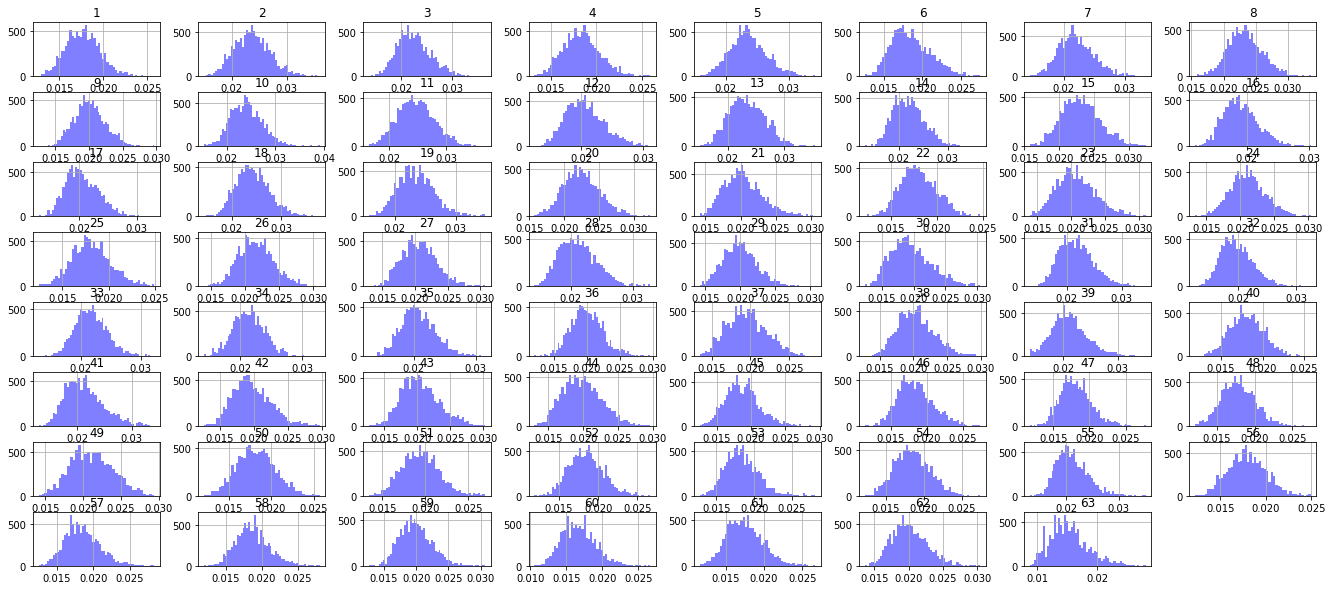

In [7]:
permutation_distributions.hist(alpha=0.5, color="blue", bins="auto", figsize=(23, 10));

In [8]:
original_statistics = nmi_wrapper(drd218.spikes, z_coords)
original_statistics = original_statistics.to_dict()

for neuron, original_stat in original_statistics.items():
    p_value = Resampler.p_value(original_stat, permutation_distributions[neuron])
    if p_value < 0.05:
        print("neuron {}: p={}".format(neuron, p_value))

neuron 1: p=0.0004
neuron 4: p=0.0
neuron 8: p=0.0
neuron 18: p=0.0004
neuron 20: p=0.0
neuron 22: p=0.008
neuron 23: p=0.028800000000000003
neuron 24: p=0.040400000000000005
neuron 25: p=0.0
neuron 27: p=0.0068000000000000005
neuron 31: p=0.0188
neuron 33: p=0.0284
neuron 34: p=0.026000000000000002
neuron 35: p=0.019200000000000002
neuron 38: p=0.0184
neuron 40: p=0.0
neuron 46: p=0.0028
neuron 49: p=0.0
neuron 50: p=0.007200000000000001
neuron 52: p=0.008
neuron 56: p=0.0392
neuron 57: p=0.009600000000000001
neuron 58: p=0.004
neuron 59: p=0.0472


In [10]:
for neuron, original_stat in original_statistics.items():
    result = Resampler.two_tailed_test(original_stat, permutation_distributions[neuron])
    print("neuron {}: result={}".format(neuron, result))

neuron 1: result=1
neuron 2: result=0
neuron 3: result=0
neuron 4: result=1
neuron 5: result=0
neuron 6: result=0
neuron 7: result=0
neuron 8: result=1
neuron 9: result=0
neuron 10: result=0
neuron 11: result=0
neuron 12: result=0
neuron 13: result=0
neuron 14: result=0
neuron 15: result=0
neuron 16: result=0
neuron 17: result=0
neuron 18: result=1
neuron 19: result=0
neuron 20: result=1
neuron 21: result=0
neuron 22: result=1
neuron 23: result=1
neuron 24: result=1
neuron 25: result=1
neuron 26: result=0
neuron 27: result=1
neuron 28: result=0
neuron 29: result=0
neuron 30: result=0
neuron 31: result=1
neuron 32: result=0
neuron 33: result=1
neuron 34: result=1
neuron 35: result=1
neuron 36: result=0
neuron 37: result=0
neuron 38: result=1
neuron 39: result=0
neuron 40: result=1
neuron 41: result=0
neuron 42: result=0
neuron 43: result=0
neuron 44: result=0
neuron 45: result=0
neuron 46: result=1
neuron 47: result=0
neuron 48: result=0
neuron 49: result=1
neuron 50: result=1
neuron 51

## Cell Selectivity

##### Use the `shuffle` function in order to create a permutation distribution, for each neuron, of the difference of means.

In [11]:
%time permutation_distributions_dataframe = Resampler.shuffle(10000, drd218.spikes, Resampler.diff_of_mean_rate, drd218.spikes_and_beh["OpenArms_centerpoint"], drd218.spikes_and_beh["ClosedArms_centerpoint"])

CPU times: user 17.7 ms, sys: 28.9 ms, total: 46.6 ms
Wall time: 13.8 s


##### Plot the permutation distributions

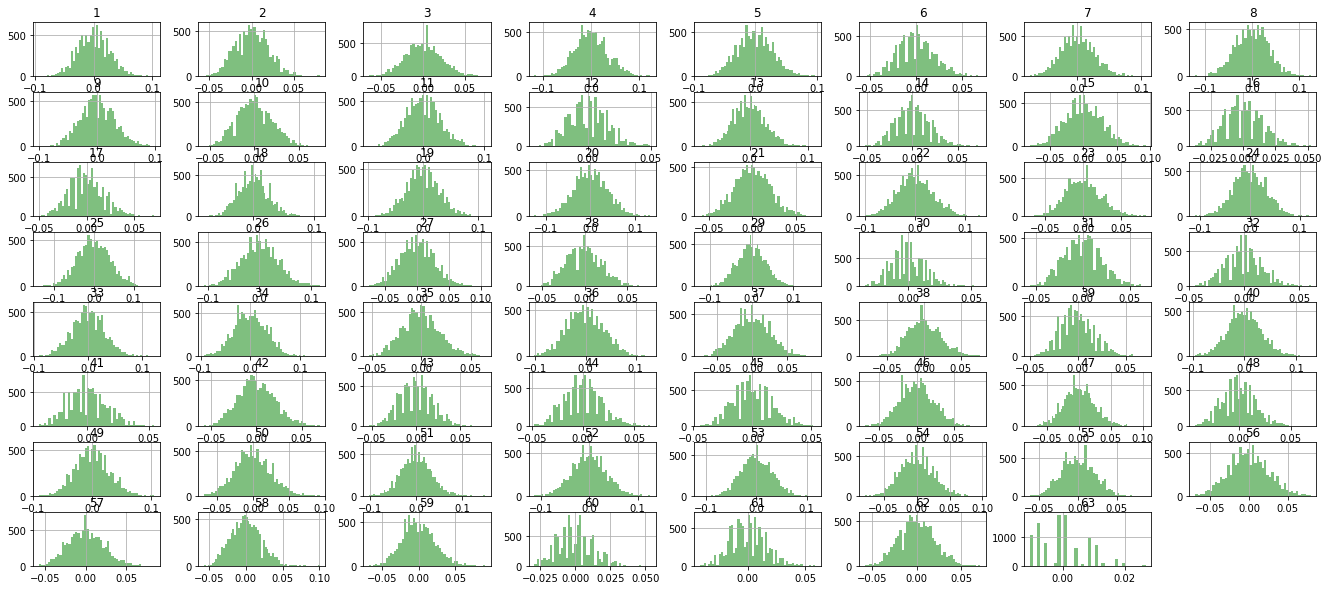

In [12]:
permutation_distributions_dataframe.hist(alpha=0.5, color="green", bins="auto", figsize=(23, 10));

##### Classify cells by the behavior for which they are selective.

In [13]:
original_diff_of_means = dict(zip(drd218.spikes.columns, Resampler.diff_of_mean_rate(drd218.spikes, drd218.spikes_and_beh["OpenArms_centerpoint"], drd218.spikes_and_beh["ClosedArms_centerpoint"])))

p_values = {}
for neuron, original_stat in original_diff_of_means.items():
    p_value = Resampler.p_value(original_diff_of_means[neuron], permutation_distributions_dataframe[neuron])
    p_values[neuron] = p_value
    print("neuron {}: p={}".format(neuron, p_value))

neuron 1: p=0.756
neuron 2: p=0.018000000000000002
neuron 3: p=0.0004
neuron 4: p=0.0444
neuron 5: p=0.19360000000000002
neuron 6: p=0.0012000000000000001
neuron 7: p=0.514
neuron 8: p=0.2528
neuron 9: p=0.2952
neuron 10: p=0.04
neuron 11: p=0.0
neuron 12: p=0.0088
neuron 13: p=0.0
neuron 14: p=0.0128
neuron 15: p=0.1504
neuron 16: p=0.39680000000000004
neuron 17: p=0.33280000000000004
neuron 18: p=0.0
neuron 19: p=0.0
neuron 20: p=0.055600000000000004
neuron 21: p=0.9552
neuron 22: p=0.0012000000000000001
neuron 23: p=0.0
neuron 24: p=0.0056
neuron 25: p=0.0044
neuron 26: p=0.0
neuron 27: p=0.0
neuron 28: p=0.062
neuron 29: p=0.0
neuron 30: p=0.0016
neuron 31: p=0.37560000000000004
neuron 32: p=0.055200000000000006
neuron 33: p=0.17200000000000001
neuron 34: p=0.0
neuron 35: p=0.0
neuron 36: p=0.0
neuron 37: p=0.0
neuron 38: p=0.5252
neuron 39: p=0.45280000000000004
neuron 40: p=0.004
neuron 41: p=0.0
neuron 42: p=0.6656000000000001
neuron 43: p=0.14400000000000002
neuron 44: p=0.0924

In [14]:
classified_cells = {}

for neuron, p_value in p_values.items():
    if p_value < 0.05 and original_diff_of_means[neuron] > 0:
        classified_cells[neuron] = "OpenArms_centerpoint"
    elif p_value < 0.05 and original_diff_of_means[neuron] < 0:
        classified_cells[neuron] = "ClosedArms_centerpoint"
    elif p_value >= 0.05:
        classified_cells[neuron] = "Not-selective"
        
classified_cells

{1: 'Not-selective',
 2: 'OpenArms_centerpoint',
 3: 'OpenArms_centerpoint',
 4: 'OpenArms_centerpoint',
 5: 'Not-selective',
 6: 'OpenArms_centerpoint',
 7: 'Not-selective',
 8: 'Not-selective',
 9: 'Not-selective',
 10: 'OpenArms_centerpoint',
 11: 'OpenArms_centerpoint',
 12: 'ClosedArms_centerpoint',
 13: 'OpenArms_centerpoint',
 14: 'OpenArms_centerpoint',
 15: 'Not-selective',
 16: 'Not-selective',
 17: 'Not-selective',
 18: 'OpenArms_centerpoint',
 19: 'OpenArms_centerpoint',
 20: 'Not-selective',
 21: 'Not-selective',
 22: 'ClosedArms_centerpoint',
 23: 'OpenArms_centerpoint',
 24: 'OpenArms_centerpoint',
 25: 'OpenArms_centerpoint',
 26: 'OpenArms_centerpoint',
 27: 'OpenArms_centerpoint',
 28: 'Not-selective',
 29: 'OpenArms_centerpoint',
 30: 'OpenArms_centerpoint',
 31: 'Not-selective',
 32: 'Not-selective',
 33: 'Not-selective',
 34: 'OpenArms_centerpoint',
 35: 'OpenArms_centerpoint',
 36: 'OpenArms_centerpoint',
 37: 'OpenArms_centerpoint',
 38: 'Not-selective',
 39: 'No

##### Plot a pie chart in order to visualize the proportions of cells that are selective for behaviors of interest.

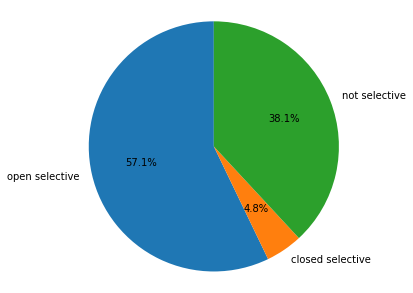

In [15]:
open_selective = 0
closed_selective = 0
not_seletive = 0

for cell, classification in classified_cells.items():
    if classification == "OpenArms_centerpoint":
        open_selective += 1
    elif classification == "ClosedArms_centerpoint":
        closed_selective += 1
    elif classification == "Not-selective":
        not_seletive += 1
        
# Plot a pie chart, where the slices will be ordered and plotted counter-clockwise:
sizes = [open_selective, closed_selective, not_seletive]
pie_chart(sizes, "open selective", "closed selective", "not selective")

## Clustering

##### The functions below are stand-alone functions meant to help with clustering analysis.

In [17]:
def compute_nmi(dataframe):
    connections = {}
    
    for neuron_pair in itertools.combinations(dataframe.columns, 2):
        H_x = entropy(dataframe[neuron_pair[0]].values)
        H_y = entropy(dataframe[neuron_pair[1]].values)
        if 0.5 * (H_x + H_y) == 0:
            nmi = 0
            connections[neuron_pair] = nmi
        else:
            nmi = entropy_cc(dataframe[neuron_pair[0]].values, dataframe[neuron_pair[1]].values)
            connections[neuron_pair] = nmi
        
    return connections

def compute_corrcoef(dataframe):
    connections = {}
    
    for neuron_pair in itertools.combinations(dataframe.columns, 2):
        if dataframe[neuron_pair[0]].std() == 0 or dataframe[neuron_pair[1]].std() == 0:
            continue

        corrcoef = np.corrcoef(dataframe[neuron_pair[0]].values, dataframe[neuron_pair[1]].values)[0][1]
        if corrcoef >= 0:
            connections[neuron_pair] = corrcoef
        
    return connections

def nmi_matrix(dataframe):
    nmi_df = pd.DataFrame(columns=dataframe.columns, index=dataframe.columns)
    for neuron_pair in itertools.combinations(dataframe.columns, 2):
        H_x = entropy(dataframe[neuron_pair[0]].values)
        H_y = entropy(dataframe[neuron_pair[1]].values)
        if 0.5 * (H_x + H_y) == 0:
            nmi = 0
        else:
            nmi = entropy_cc(dataframe[neuron_pair[0]].values, dataframe[neuron_pair[1]].values)
        
        nmi_df.iat[neuron_pair[0]-1, neuron_pair[1]-1] = nmi
        nmi_df.iat[neuron_pair[1]-1, neuron_pair[0]-1] = nmi
    
    nmi_df.fillna(0, inplace=True)
    return nmi_df

def plot_traces(clusters, mouse, **kwargs):
    figsize = kwargs.get("figsize", (15, 6))
    hspace = kwargs.get("hspace", 0.0)
    file_name = kwargs.get("file_name", "neural_traces.png")
    total_subplots = 0
    
    for cluster in clusters:
        if len(clusters[cluster]) > 1:
            total_subplots += len(clusters[cluster])
            
    cmap = get_cmap(max(clusters.keys())+1, name="Dark2")
    fig, ax = plt.subplots(total_subplots, 1, figsize=figsize)
    
    all_frames = []
    all_frames.append(get_continuous_beh_indices(mouse, "Center", framerate=1, num_of_sec=1))
    all_frames.append(get_continuous_beh_indices(mouse, "OpenArms_centerpoint", framerate=1, num_of_sec=1))
    all_frames.append(get_continuous_beh_indices(mouse, "ClosedArms_centerpoint", framerate=1, num_of_sec=1))
    all_frames.append(get_continuous_beh_indices(mouse, "Head_Dips", framerate=1, num_of_sec=1))
    
    ax_index = 0
    dataframe = mouse.cell_transients
    background_colors = ["red", "orange", "lightcyan", "grey"]
    
    for cluster in clusters:
        if len(clusters[cluster]) > 1:
            for index in range(0, len(clusters[cluster])):
                ax[ax_index].plot(dataframe.index, dataframe[clusters[cluster][index]], c=cmap(cluster), lw=2)
                for i, frames in enumerate(all_frames):
                    for time_period in frames:
                        ax[ax_index].axvspan(time_period[0], time_period[1], alpha=0.1, color=background_colors[i])
                        ax[ax_index].axis("off")
                ax_index += 1
            
    plt.subplots_adjust(wspace=0, hspace=hspace)
    
    if kwargs.get("save", False):
        plt.savefig(file_name, dpi=300)
        
    plt.show();
    
def get_cmap(n, name="tab20"):
    """ Returns a function that maps each index in 0,1,...,n-1 
        to a distinct RGB color; the keyword argument name must 
        be a standard mpl colormap name.
    """
    return plt.cm.get_cmap(name, n)

def get_continuous_beh_indices(mouse, behavior, **kwargs):
    """Find all frames of continuous behavior
    """
    indices = []
    continuous_beh = {}
    num_of_sec = kwargs.get("seconds", 5)
    framerate = kwargs.get("framerate", 10)

    for row in mouse.spikes_and_beh.itertuples():
        if getattr(row, behavior) == 1:
            continuous_beh[row[0]] = 1
        else:
            if len(continuous_beh) >= num_of_sec * framerate:
                
                # Note the start frame, and the end frame for when the animal entered the area.
                begin = list(continuous_beh.keys())[0]
                end = list(continuous_beh.keys())[len(list(continuous_beh.keys()))-1]
                indices.append((begin, end))

            continuous_beh.clear()
                
    return indices

def get_neuron_positions(neuron_network, coordinates_df):
    """Create a dictionary of all the neuron cartestian coordinates"""
    pos = dict()

    for neuron in neuron_network.neurons:
        if neuron not in pos:
            pos[neuron] = (coordinates_df.loc[neuron, :]["x"], -coordinates_df.loc[neuron, :]["y"])
            
    return pos

##### We load & preprocess all the data for another mouse.

In [18]:
c = pd.read_csv(find_file("Hen_Lab/Mice", "Drd87_EPM_C_thresh.csv"), header=None)
s = pd.read_csv(find_file("Hen_Lab/Mice", "Drd87_EPM_S_thresh.csv"), header=None)
behavior = pd.read_csv(find_file("Hen_Lab/Mice", "DRD87_EPM_NEW_BEH.csv"), header=None)

# Reindex neuron column vectors from 0,1,2,...,n ---> 1,2,3,...,n,n+1
s.columns = [col+1 for col in s.columns]
c.columns = [col+1 for col in c.columns]

behavior_column_names = ['Trial_time',
                         'Recording_time',
                         'X_center',
                         'Y_center',
                         'Area',
                         'Areachange',
                         'Elongation',
                         'Distance_moved',
                         'Velocity',
                         'Arena_centerpoint',
                         'Open1_centerpoint',
                         'Open2_centerpoint',
                         'Closed1_centerpoint',
                         'Closed2_centerpoint',
                         'OpenArms_centerpoint',
                         'ClosedArms_centerpoint',
                         'Hardware_command',
                         'Hardware_command_2',
                         'Hardware_command_3',
                         'Hardware_command_4',
                         'Result_1',
                         "Head_Dips"]

# Drop every 3rd row from the behavior dataframe 
behavior = Mouse.downsample_dataframe(behavior, 3)

# Rename the behavior dataframe columns and drop all useless column vectors.
behavior.columns = behavior_column_names
behavior.drop(["Hardware_command", "Hardware_command_2", "Hardware_command_3", "Hardware_command_4", "Result_1"], axis=1, inplace=True)

# Create a Mouse object to store all of the data for a particular mouse
drd87 = Mouse(cell_transients=c, spikes=s, behavior=behavior)

# Convert dataframe to a boolean matrix, where spikes := 1 and no spike := 0
drd87.spikes = drd87.spikes.where(drd87.spikes==0, 1)

# Add "Center" column to concatenated dataframe
center = (drd87.spikes_and_beh["OpenArms_centerpoint"]) + (drd87.spikes_and_beh["ClosedArms_centerpoint"])
center = 1-center
drd87.spikes_and_beh["Center"] = center

##### We read in the cartesian coordinates of drd87's neurons, as imaged.

In [19]:
coordinates = pd.read_csv(find_file("Hen_Lab/Mice", "EPM_NO_OFT_POPP_centroids.csv"), header=None)
coordinates.columns = ['x', 'y']

# Reset the index so that it starts from 1, since it is more natural to enumerate neurons as 1, 2, ..., n
coordinates.index = pd.RangeIndex(1, len(coordinates.index)+1)

##### We find all possible clusters of neurons for drd87 in EPM during the overall session. 

In [20]:
# connections = compute_corrcoef(drd87.auc_df)
connections = compute_nmi(drd87.spikes)
drd87_graph = NeuronNetwork(drd87.spikes.columns, connections)
pos = get_neuron_positions(drd87_graph, coordinates)
  
# X = drd87.auc_df.corr().where(drd87.auc_df.corr() >= 0, 0)
X = nmi_matrix(drd87.spikes)
clusters = affinity_propagation(X)

##### We plot the imaged neurons by their actual positions, and we color code each neuron by its respective cluster.

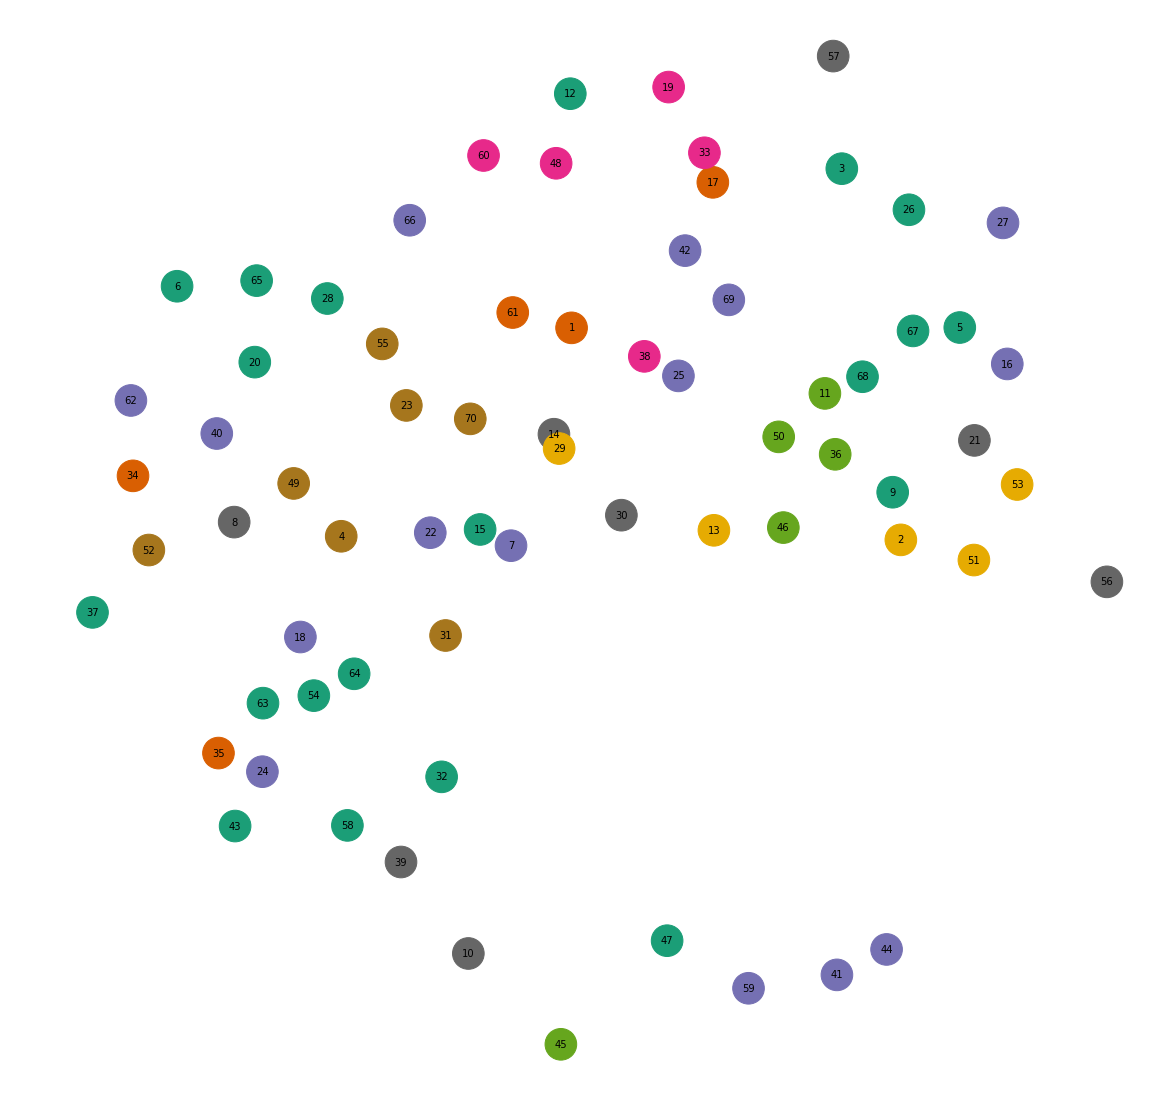

In [21]:
node_colors = [clusters[key] for key in sorted(clusters.keys())]
drd87_graph.plot(pos=pos, node_colors=node_colors, figsize=(20,20), node_size=1000, draw_edges=False, save=False, file_name="drd87_overall_nmi.png")

##### We plot the continuous time series plots, for each neuron that was assigned to a cluster with $2$ or more neurons. Each time series plot is color coded its respective cluster. 

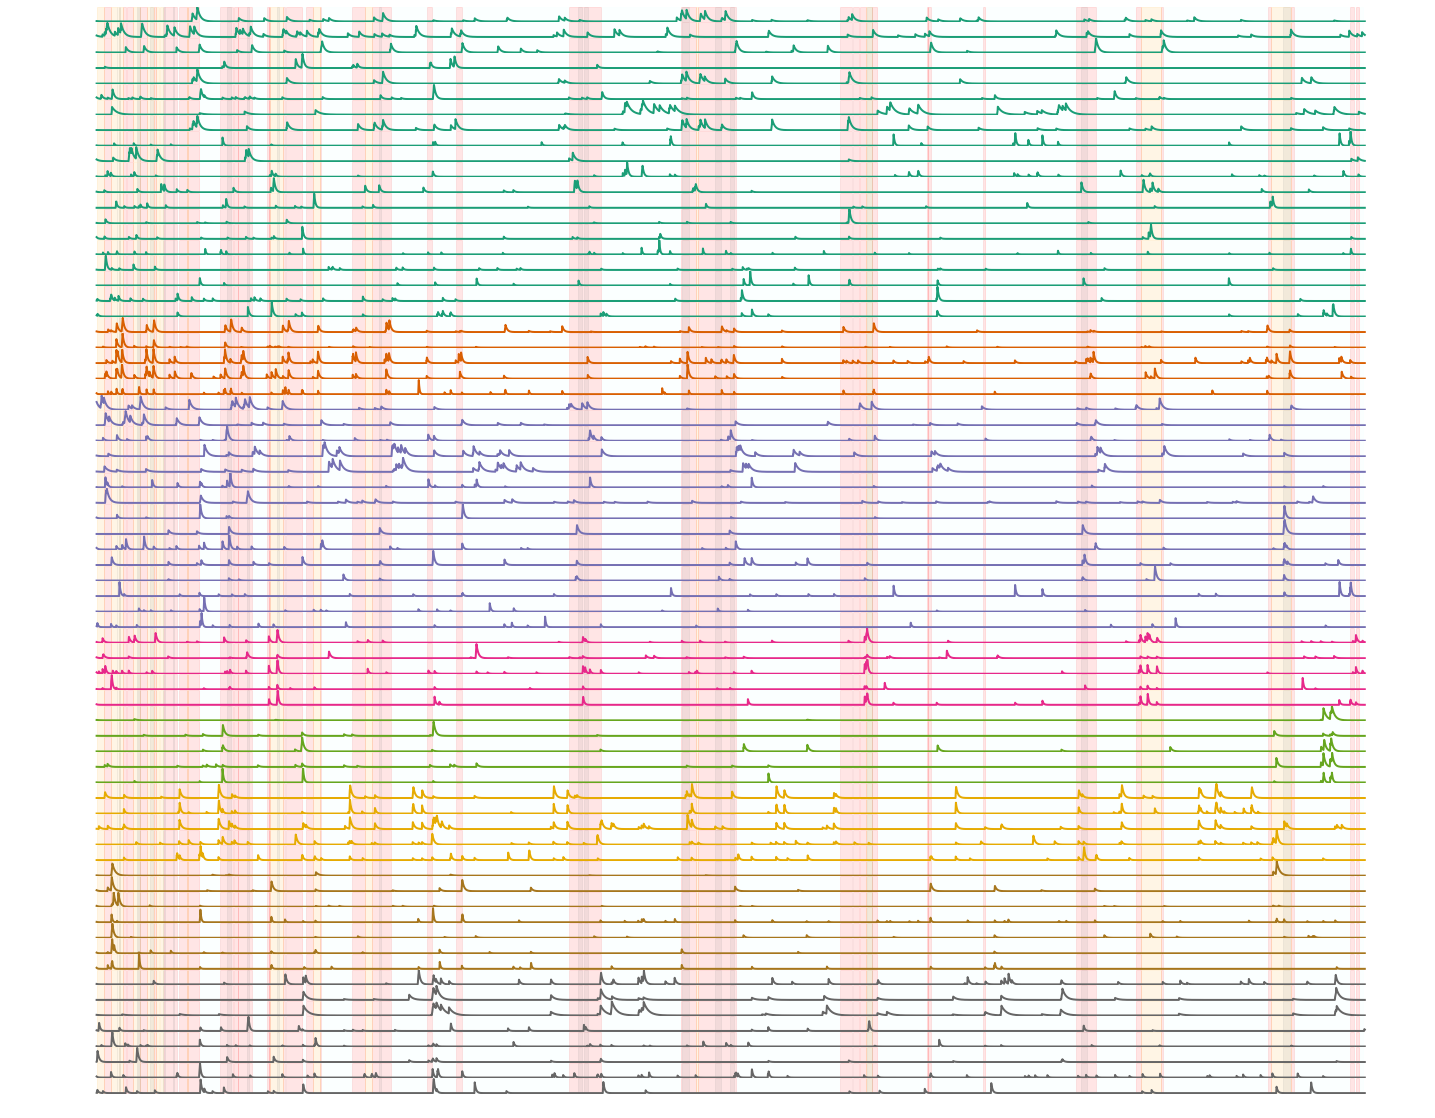

In [22]:
clusters = extract_clusters(clusters)
plot_traces(clusters, drd87, figsize=(25, 20), hspace=0.0, save=False, file_name="drd87_cluster_traces.png")

## Graph Theoretical Analysis

##### We begin by computing the mutual information between all possible pairs of neurons. We provide the `NeuronNetwork` object with the names of the neurons (nodes), and the functional connectivity (mutual information) between all pairs of neurons.

In [23]:
connections = compute_nmi(drd87.spikes)
drd87_graph = NeuronNetwork(drd87.spikes.columns, connections)

##### Compute the mean [betweeness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) of drd87's neuron network.

In [24]:
drd87_graph.mean_betw_cent()

0.018420411642918036

##### Compute the average clustering coefficient for drd87's network of neurons.

In [25]:
nx.average_clustering(drd87_graph.network, weight="weight")

0.07723441247126059

##### Compute the average clustering coefficient for each extracted cluster.

In [26]:
for _, cluster in clusters.items():
    avg_cluster_coeff = np.mean(list(nx.clustering(drd87_graph.network, weight="weight", nodes=cluster).values()))
    print("avg clustering coefficient of {} = {}".format(cluster, avg_cluster_coeff))    

avg clustering coefficient of [3, 5, 6, 9, 12, 15, 20, 26, 28, 32, 37, 43, 47, 54, 58, 63, 64, 65, 67, 68] = 0.07181318169494894
avg clustering coefficient of [1, 17, 34, 35, 61] = 0.07529903012335663
avg clustering coefficient of [7, 16, 18, 22, 24, 25, 27, 40, 41, 42, 44, 59, 62, 66, 69] = 0.07654298121022864
avg clustering coefficient of [19, 33, 38, 48, 60] = 0.07775282668436019
avg clustering coefficient of [11, 36, 45, 46, 50] = 0.07916097302025091
avg clustering coefficient of [2, 13, 29, 51, 53] = 0.07743066149772601
avg clustering coefficient of [4, 23, 31, 49, 52, 55, 70] = 0.08940410332542754
avg clustering coefficient of [8, 10, 14, 21, 30, 39, 56, 57] = 0.08099429262867129


##### Compute the mean shortest path length of drd87's network of neurons. Recall: "random and complex networks have short mean path lengths (high global efficiency of parallel information transfer)" (Bullmore & Sporns 2009)

In [27]:
drd87_graph.avg_shortest_path_len()

0.02780044311046306

##### Compute the small-worldness of drd87's network of neurons. Recall: "a convenient single-number summary of small-worldness is thus the ratio of the clustering coefficient to the path length after both metrics have been standardized by comparing their values to those in equivalent random networks" (Bullmore & Sporns 2009)

In [28]:
drd87_graph.small_worldness()

2.7781719940353184

##### We the compute the degree assortativity of the neuron network.

In [29]:
nx.degree_pearson_correlation_coefficient(drd87_graph.network, weight="weight")

-0.014492753623188413